In [780]:
# Import the needed referances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.ensemble import AdaBoostClassifier

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

# Sklearn preprocessing NaN
from sklearn.preprocessing import Imputer


from lightgbm import LGBMClassifier

# FUNCTIONS: MISSING VALUES

In [781]:
# Examine missing values
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

# LOAD DATASET

In [782]:
# Load train and test file 

train_dataset_orig = pd.read_csv('/home/convidado/Denise/TItanic/all/train.csv')
test_dataset_orig = pd.read_csv('/home/convidado/Denise/TItanic/all/test.csv')

print("train_dataset.shape: " + str(train_dataset_orig.shape))
print("test_dataset.shape: " + str(test_dataset_orig.shape))

train_dataset_orig.head()

train_dataset.shape: (891, 12)
test_dataset.shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [783]:
# Number of each type of column
train_dataset_orig.dtypes.value_counts()

int64      5
object     5
float64    2
dtype: int64

In [784]:
# Number of unique classes in each object column
train_dataset_orig.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [785]:
# Correlations
train_dataset_orig.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


# EXPLORE DATA

# Survival by Age, Port and Gender

<Figure size 2880x720 with 0 Axes>

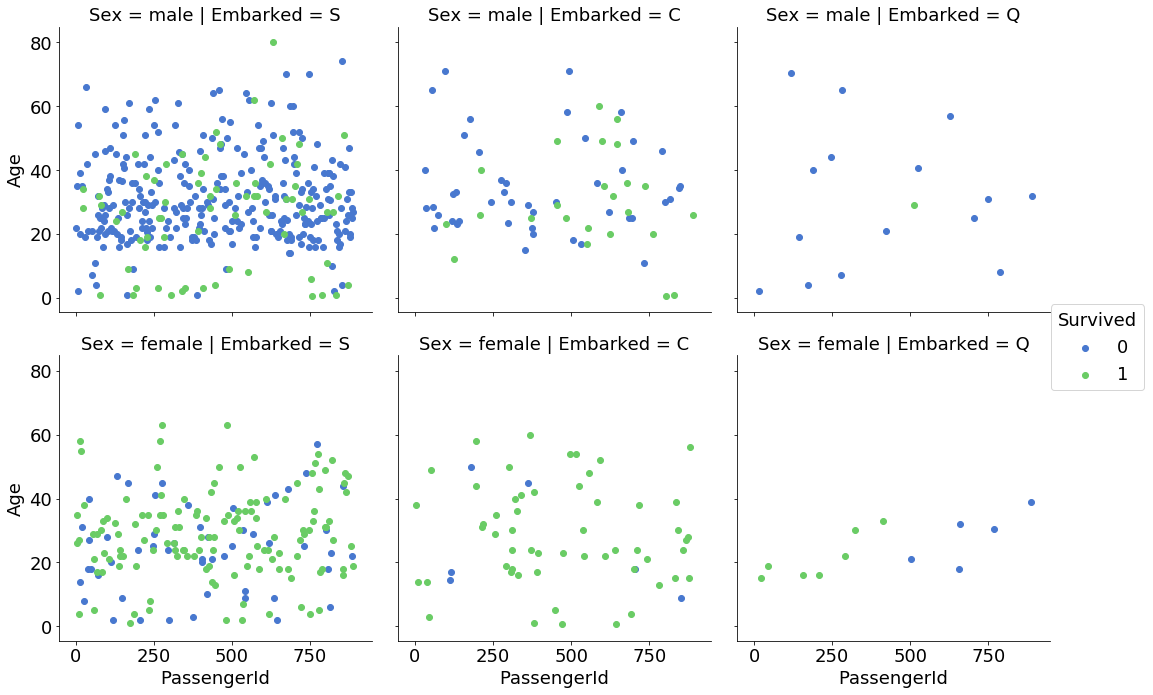

In [786]:
plt.figure(figsize=(40,10))

grid = sns.FacetGrid(train_dataset_orig, col = "Embarked", row = "Sex", hue = "Survived", palette = 'muted',size = 5)
grid = grid.map(plt.scatter, "PassengerId", "Age")


grid.add_legend()
grid

# Survival by Pclass, Sex, Gender

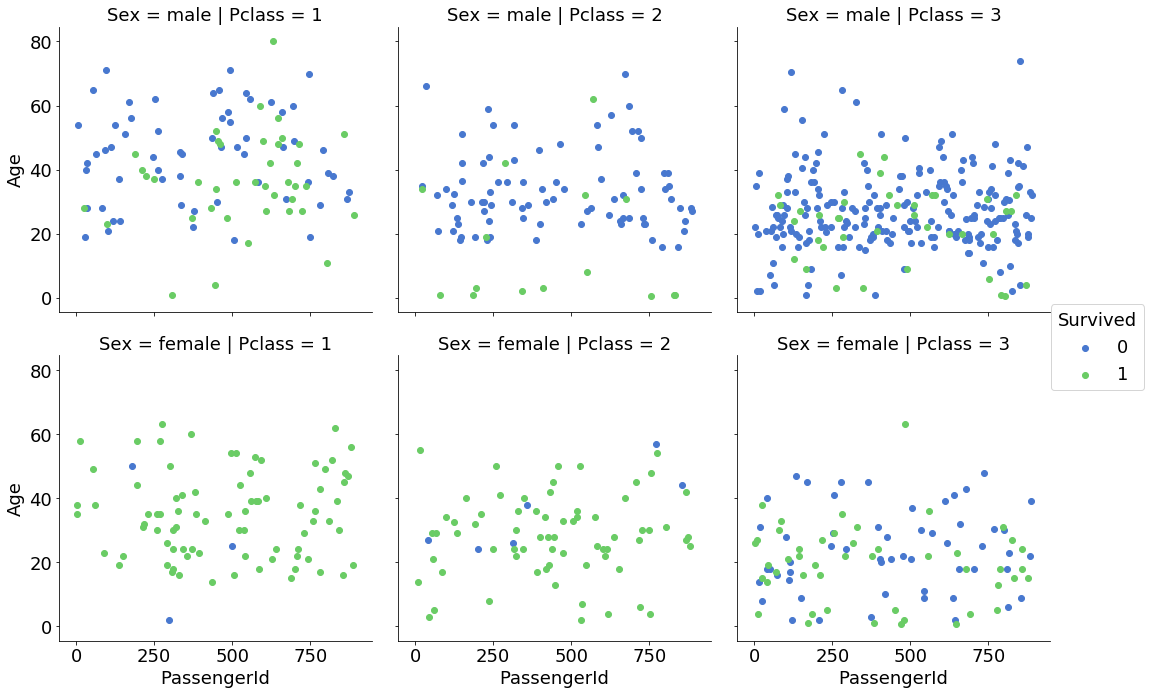

In [787]:
grid = sns.FacetGrid(train_dataset_orig, col = "Pclass", row = "Sex", hue = "Survived", palette = 'muted',size = 5)
grid = grid.map(plt.scatter, "PassengerId", "Age")


grid.add_legend()
grid

# Survive by age

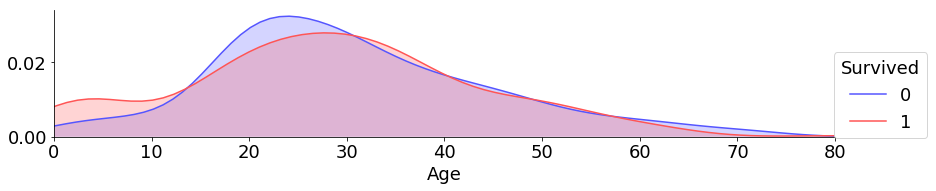

In [788]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(train_dataset_orig, hue="Survived",palette = 'seismic',aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_dataset_orig['Age'].max()))
facet.add_legend()

# FEATURE ENGINEERING

# Name

In [789]:
# -------------------- Processing "Name" --------------------

# Create a new feature title and drop the feature Name
train_dataset_orig["Title"] = train_dataset_orig["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)
test_dataset_orig["Title"] = test_dataset_orig["Name"].str.extract(' ([A-Za-z]+)\.', expand=False)

train_dataset = train_dataset_orig.drop(["Name"], axis = 1)
test_dataset = test_dataset_orig.drop(["Name"], axis = 1)

# Check the most commons titles
print("\nTitles in train_dataset: ")
print(pd.crosstab(train_dataset['Title'], train_dataset['Sex']))
print("--------------------------------------------------------")
print("\nTitles in test_dataset:")
print(pd.crosstab(test_dataset['Title'], test_dataset['Sex']))

# Replace some titles: replace the lowest commons titles with "Rare", replace "Mlle", "Ms, "Mme" with "Miss",
#"Miss" and "Mrs", respectively.
train_dataset['Title'] = train_dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
test_dataset['Title'] = test_dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

train_dataset['Title'] = train_dataset['Title'].replace('Mlle', 'Miss')
train_dataset['Title'] = train_dataset['Title'].replace('Ms', 'Miss')
train_dataset['Title'] = train_dataset['Title'].replace('Mme', 'Mrs')

test_dataset['Title'] = test_dataset['Title'].replace('Mlle', 'Miss')
test_dataset['Title'] = test_dataset['Title'].replace('Ms', 'Miss')
test_dataset['Title'] = test_dataset['Title'].replace('Mme', 'Mrs')


print("--------------------------------------------------------")

train_dataset.head()


Titles in train_dataset: 
Sex       female  male
Title                 
Capt           0     1
Col            0     2
Countess       1     0
Don            0     1
Dr             1     6
Jonkheer       0     1
Lady           1     0
Major          0     2
Master         0    40
Miss         182     0
Mlle           2     0
Mme            1     0
Mr             0   517
Mrs          125     0
Ms             1     0
Rev            0     6
Sir            0     1
--------------------------------------------------------

Titles in test_dataset:
Sex     female  male
Title               
Col          0     2
Dona         1     0
Dr           0     1
Master       0    21
Miss        78     0
Mr           0   240
Mrs         72     0
Ms           1     0
Rev          0     2
--------------------------------------------------------


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr


# Visualize Title data

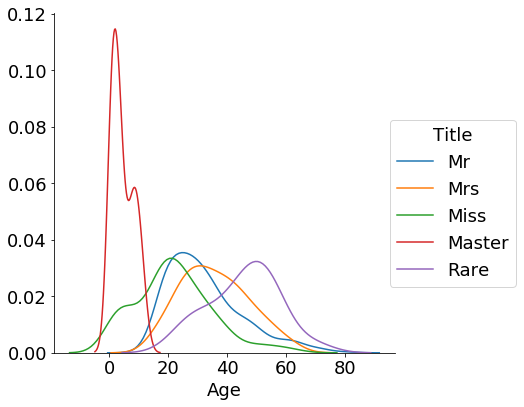

In [790]:
# Groupby title, mean survive
train_dataset[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()
# plot age distribution by title
facet = sns.FacetGrid(data = train_dataset, hue = "Title", legend_out=True, size = 6)
facet = facet.map(sns.kdeplot, "Age")
facet.add_legend();

# Fare

In [791]:
#Fill missing Fare value based on mean fare for that Pclass 
for x in range(len(train_dataset["Fare"])):
    if pd.isnull(train_dataset["Fare"][x]):
        pclass = train_dataset["Pclass"][x] #Pclass = 3
        train_dataset["Fare"][x] = round(train_dataset[train_dataset["Pclass"] == pclass]["Fare"].mean(), 8)
        
# Fill missing Fare value  based on mean fare for that Pclass         
for x in range(len(test_dataset["Fare"])):
    if pd.isnull(test_dataset["Fare"][x]):
        pclass = test_dataset["Pclass"][x] #Pclass = 3
        test_dataset["Fare"][x] = round(test_dataset[test_dataset["Pclass"] == pclass]["Fare"].mean(), 8)
        
# Label Fare bands
train_dataset["FareBand"] = pd.qcut(train_dataset['Fare'], 8, labels = ["fare-1", "fare-2", "fare-3", "fare-4",\
                                                                        "fare-5","fare-6","fare-7","fare-8"])
train_dataset["FareBand"] = pd.qcut(train_dataset['Fare'], 8, labels = ["fare-1", "fare-2", "fare-3", "fare-4",\
                                                                        "fare-5","fare-6","fare-7","fare-8"])
test_dataset["FareBand"] = pd.qcut(test_dataset['Fare'], 8, labels = ["fare-1", "fare-2", "fare-3", "fare-4",\
                                                                        "fare-5","fare-6","fare-7","fare-8"])


train_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareBand
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,fare-1
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,fare-8
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,fare-3
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,fare-7
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,fare-3


# Age

In [792]:
# -------------------- Processing "Age" --------------------

# Create a new feature AgeRange
train_dataset['AgeRange'] = 'Child'
train_dataset.loc[(train_dataset['Age'] >= 15) & (train_dataset['Age'] < 31), 'AgeRange'] = 'Young'
train_dataset.loc[(train_dataset['Age'] >= 31) & (train_dataset['Age'] < 41), 'AgeRange'] = 'Young adult'
train_dataset.loc[(train_dataset['Age'] >= 41) & (train_dataset['Age'] < 51), 'AgeRange'] = 'Adult'
train_dataset.loc[(train_dataset['Age'] >= 51) & (train_dataset['Age'] < 61), 'AgeRange'] = 'Adult-Senior'
train_dataset.loc[(train_dataset['Age'] >= 61), 'AgeRange'] = 'Senior'


test_dataset['AgeRange'] = 'Child'
test_dataset.loc[(test_dataset['Age'] >= 15) & (test_dataset['Age'] < 31), 'AgeRange'] = 'Young'
test_dataset.loc[(test_dataset['Age'] >= 31) & (test_dataset['Age'] < 41), 'AgeRange'] = 'Young adult'
test_dataset.loc[(test_dataset['Age'] >= 41) & (test_dataset['Age'] < 51), 'AgeRange'] = 'Adult'
test_dataset.loc[(test_dataset['Age'] >= 51) & (test_dataset['Age'] < 61), 'AgeRange'] = 'Adult-Senior'
test_dataset.loc[(test_dataset['Age'] >= 61), 'AgeRange'] = 'Senior'


train_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareBand,AgeRange
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,fare-1,Young
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,fare-8,Young adult
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,fare-3,Young
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,fare-7,Young adult
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,fare-3,Young adult


# Women with child

In [793]:
train_dataset['Woman_with_child'] = (train_dataset['Title'] == 'Mrs') & (train_dataset['Parch'] > 0)
train_dataset['Woman_with_child'] = train_dataset['Woman_with_child'].astype(int)

test_dataset['Woman_with_child'] = (test_dataset['Title'] == 'Mrs') & (test_dataset['Parch'] > 0)
test_dataset['Woman_with_child'] = test_dataset['Woman_with_child'].astype(int)

train_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FareBand,AgeRange,Woman_with_child
0,1,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,fare-1,Young,0
1,2,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,fare-8,Young adult,0
2,3,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,fare-3,Young,0
3,4,1,1,female,35.0,1,0,113803,53.1000,C123,S,Mrs,fare-7,Young adult,0
4,5,0,3,male,35.0,0,0,373450,8.0500,NaN,S,Mr,fare-3,Young adult,0


# Familiy size

In [794]:
# -------------------- Processing "SibSp" and "Parch" --------------------
# Create a new feature FamilySize which combines Parch and SibSp and drop Parch and SibSp
train_dataset['FamilySize'] = train_dataset['SibSp'] + train_dataset['Parch'] + 1
test_dataset['FamilySize'] = test_dataset['SibSp'] + test_dataset['Parch'] + 1

train_dataset = train_dataset.drop(["SibSp"], axis = 1).drop(["Parch"], axis = 1)
test_dataset = test_dataset.drop(["SibSp"], axis = 1).drop(["Parch"], axis = 1)

# Create new column "FamilySizeGroup" and assign "Alone", "Small" and "Big"
train_dataset['FamilySizeGroup'] = 'Small'
train_dataset.loc[train_dataset['FamilySize'] == 1, 'FamilySizeGroup'] = 'Alone'
train_dataset.loc[train_dataset['FamilySize'] >= 5, 'FamilySizeGroup'] = 'Big'
train_dataset = train_dataset.drop(["FamilySize"], axis = 1)

test_dataset['FamilySizeGroup'] = 'Small'
test_dataset.loc[test_dataset['FamilySize'] == 1, 'FamilySizeGroup'] = 'Alone'
test_dataset.loc[test_dataset['FamilySize'] >= 5, 'FamilySizeGroup'] = 'Big'
test_dataset = test_dataset.drop(["FamilySize"], axis = 1)

train_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Title,FareBand,AgeRange,Woman_with_child,FamilySizeGroup
0,1,0,3,male,22.0,A/5 21171,7.2500,NaN,S,Mr,fare-1,Young,0,Small
1,2,1,1,female,38.0,PC 17599,71.2833,C85,C,Mrs,fare-8,Young adult,0,Small
2,3,1,3,female,26.0,STON/O2. 3101282,7.9250,NaN,S,Miss,fare-3,Young,0,Alone
3,4,1,1,female,35.0,113803,53.1000,C123,S,Mrs,fare-7,Young adult,0,Small
4,5,0,3,male,35.0,373450,8.0500,NaN,S,Mr,fare-3,Young adult,0,Alone


# Visualize FamilySizeGroup

<Figure size 2880x720 with 0 Axes>

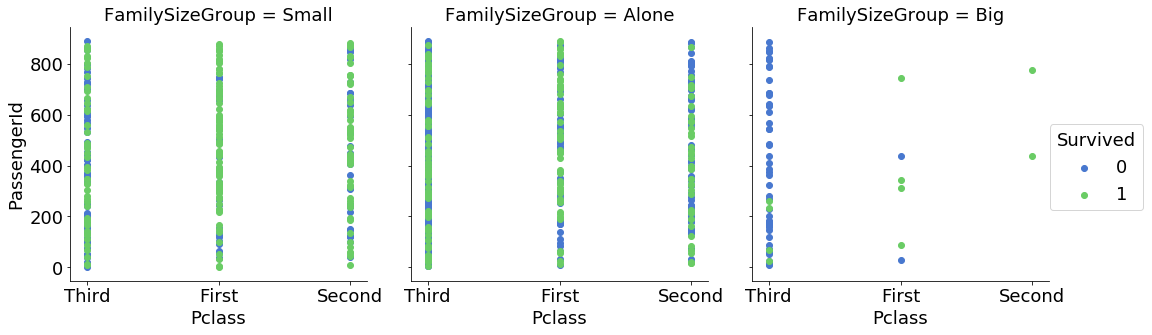

In [825]:
plt.figure(figsize=(40,10))

grid = sns.FacetGrid(train_dataset, col = "FamilySizeGroup", hue = "Survived", palette = 'muted',size = 5)
grid = grid.map(plt.scatter, "Pclass", "PassengerId")


grid.add_legend()
grid

# Cabin

In [795]:
# -------------------- Processing "Cabin" --------------------

# Create a new feature Cabine_type and drop the feature Cabine
train_dataset["Cabin_type"] = train_dataset_orig["Cabin"].str[0]
test_dataset["Cabin_type"]  = test_dataset_orig["Cabin"].str[0]

train_dataset = train_dataset.drop(columns = ["Cabin"])
test_dataset = test_dataset.drop(columns = ["Cabin"])

train_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Title,FareBand,AgeRange,Woman_with_child,FamilySizeGroup,Cabin_type
0,1,0,3,male,22.0,A/5 21171,7.2500,S,Mr,fare-1,Young,0,Small,NaN
1,2,1,1,female,38.0,PC 17599,71.2833,C,Mrs,fare-8,Young adult,0,Small,C
2,3,1,3,female,26.0,STON/O2. 3101282,7.9250,S,Miss,fare-3,Young,0,Alone,NaN
3,4,1,1,female,35.0,113803,53.1000,S,Mrs,fare-7,Young adult,0,Small,C
4,5,0,3,male,35.0,373450,8.0500,S,Mr,fare-3,Young adult,0,Alone,NaN


# Pclass

In [796]:
# -------------------- Processing "Pclass" --------------------

pclass =["First", "Second", "Third"] 

for i in range(3):
    train_dataset['Pclass'] = train_dataset['Pclass'].replace(i+1, pclass[i])
    test_dataset['Pclass'] = test_dataset['Pclass'].replace(i+1, pclass[i])
    
train_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Embarked,Title,FareBand,AgeRange,Woman_with_child,FamilySizeGroup,Cabin_type
0,1,0,Third,male,22.0,A/5 21171,7.2500,S,Mr,fare-1,Young,0,Small,NaN
1,2,1,First,female,38.0,PC 17599,71.2833,C,Mrs,fare-8,Young adult,0,Small,C
2,3,1,Third,female,26.0,STON/O2. 3101282,7.9250,S,Miss,fare-3,Young,0,Alone,NaN
3,4,1,First,female,35.0,113803,53.1000,S,Mrs,fare-7,Young adult,0,Small,C
4,5,0,Third,male,35.0,373450,8.0500,S,Mr,fare-3,Young adult,0,Alone,NaN


# Drop categories

In [797]:
# Drop Ticket and Cabin feature :categorical features with a lot of categories, suposition: correlation with Pclass 
# and Fare

train_dataset = train_dataset.drop(columns = ["Ticket"])
test_dataset = test_dataset.drop(columns = ["Ticket"])

train_dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Title,FareBand,AgeRange,Woman_with_child,FamilySizeGroup,Cabin_type
0,1,0,Third,male,22.0,7.2500,S,Mr,fare-1,Young,0,Small,NaN
1,2,1,First,female,38.0,71.2833,C,Mrs,fare-8,Young adult,0,Small,C
2,3,1,Third,female,26.0,7.9250,S,Miss,fare-3,Young,0,Alone,NaN
3,4,1,First,female,35.0,53.1000,S,Mrs,fare-7,Young adult,0,Small,C
4,5,0,Third,male,35.0,8.0500,S,Mr,fare-3,Young adult,0,Alone,NaN


# One hot encoding: categorical featres

In [696]:
# One hot encoding of  categorical variables
train_dataset = pd.get_dummies(train_dataset)
test_dataset = pd.get_dummies(test_dataset)

print('Training Features shape: ', train_dataset.shape)
print('Testing Features shape: ', test_dataset.shape)

Training Features shape:  (891, 43)
Testing Features shape:  (418, 41)


In [697]:
train_dataset.columns

Index(['PassengerId', 'Survived', 'Age', 'Fare', 'Woman_with_child',
       'Pclass_First', 'Pclass_Second', 'Pclass_Third', 'Sex_female',
       'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'FareBand_fare-1',
       'FareBand_fare-2', 'FareBand_fare-3', 'FareBand_fare-4',
       'FareBand_fare-5', 'FareBand_fare-6', 'FareBand_fare-7',
       'FareBand_fare-8', 'AgeRange_Adult', 'AgeRange_Adult-Senior',
       'AgeRange_Child', 'AgeRange_Senior', 'AgeRange_Young',
       'AgeRange_Young adult', 'FamilySizeGroup_Alone', 'FamilySizeGroup_Big',
       'FamilySizeGroup_Small', 'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T'],
      dtype='object')

In [698]:
test_dataset.columns

Index(['PassengerId', 'Age', 'Fare', 'Woman_with_child', 'Pclass_First',
       'Pclass_Second', 'Pclass_Third', 'Sex_female', 'Sex_male', 'Embarked_C',
       'Embarked_Q', 'Embarked_S', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Rare', 'FareBand_fare-1', 'FareBand_fare-2',
       'FareBand_fare-3', 'FareBand_fare-4', 'FareBand_fare-5',
       'FareBand_fare-6', 'FareBand_fare-7', 'FareBand_fare-8',
       'AgeRange_Adult', 'AgeRange_Adult-Senior', 'AgeRange_Child',
       'AgeRange_Senior', 'AgeRange_Young', 'AgeRange_Young adult',
       'FamilySizeGroup_Alone', 'FamilySizeGroup_Big', 'FamilySizeGroup_Small',
       'Cabin_type_A', 'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G'],
      dtype='object')

In [699]:
test_dataset["Cabi_type_T"] = 0

# Drop Age and Fare

In [700]:
# Drop Age and Fare features

train_dataset = train_dataset.drop(columns= ['Age'])
test_dataset = test_dataset.drop(columns= ['Age'])

train_dataset = train_dataset.drop(columns= ['Fare'])
test_dataset = test_dataset.drop(columns= ['Fare'])

train_dataset.head()

,PassengerId,Survived,Woman_with_child,Pclass_First,Pclass_Second,Pclass_Third,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,FamilySizeGroup_Big,FamilySizeGroup_Small,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T
0,1,0,0,0,0,1,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
1,2,1,0,1,0,0,1,0,1,0,...,0,1,0,0,1,0,0,0,0,0
2,3,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,1,0,0,1,0,0,0,...,0,1,0,0,1,0,0,0,0,0
4,5,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


# Correlations

In [715]:
correlations = train_dataset.corr()['Survived'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 Title_Master             0.085221
Pclass_Second            0.093349
Cabin_type_C             0.114652
Cabin_type_E             0.145321
Cabin_type_D             0.150716
Embarked_C               0.168240
Cabin_type_B             0.175095
Woman_with_child         0.175967
FareBand_fare-8          0.229799
FamilySizeGroup_Small    0.279855
Pclass_First             0.285904
Title_Miss               0.335636
Title_Mrs                0.341994
Sex_female               0.543351
Survived                 1.000000
Name: Survived, dtype: float64

Most Negative Correlations:
 Title_Mr                -0.549199
Sex_male                -0.543351
Pclass_Third            -0.322308
FamilySizeGroup_Alone   -0.203367
FareBand_fare-1         -0.156873
Embarked_S              -0.155660
FareBand_fare-3         -0.144001
FareBand_fare-2         -0.133861
FamilySizeGroup_Big     -0.125147
AgeRange_Senior         -0.051224
AgeRange_Young          -0.032524
Cabin_type_T            -0

# Get the final training examples

In [701]:
# Separate the target colum
train_dataset_target= train_dataset["Survived"]

train_dataset_final = train_dataset.drop(columns = ['Survived', 'PassengerId'])
test_dataset_final = test_dataset.drop(columns = ["PassengerId"])

# Print out the new shapes
print('Training final dataset shape: ',train_dataset_final.shape)
print('Training final target shape:  ', train_dataset_target.shape)
print('Testfinal dataset shape:  ', test_dataset_final.shape)

Training final dataset shape:  (891, 39)
Training final target shape:   (891,)
Testfinal dataset shape:   (418, 39)


In [702]:
# Normalization and fill missing values

# Copy of the testing data
test = test_dataset_final.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to unit scale (mean = 0 and variance = 1)
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train_dataset_final)

# Transform both training and testing data
train = imputer.transform(train_dataset_final)
test = imputer.transform(test_dataset_final)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (891, 39)
Testing data shape:  (418, 39)


# MACHINE LEARNING MODEL

# Random forest model

In [717]:
# Logistic Regression

rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=10,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1)
rf.fit(train,train_dataset_target)

y_pred = rf.predict(train)

print("Oob: %.4f" % rf.oob_score_)

        
accuracy = accuracy_score(y_pred, train_dataset_target)
print("Accuracy: %.4f " % accuracy)

Oob: 0.8272
Accuracy: 0.8765 


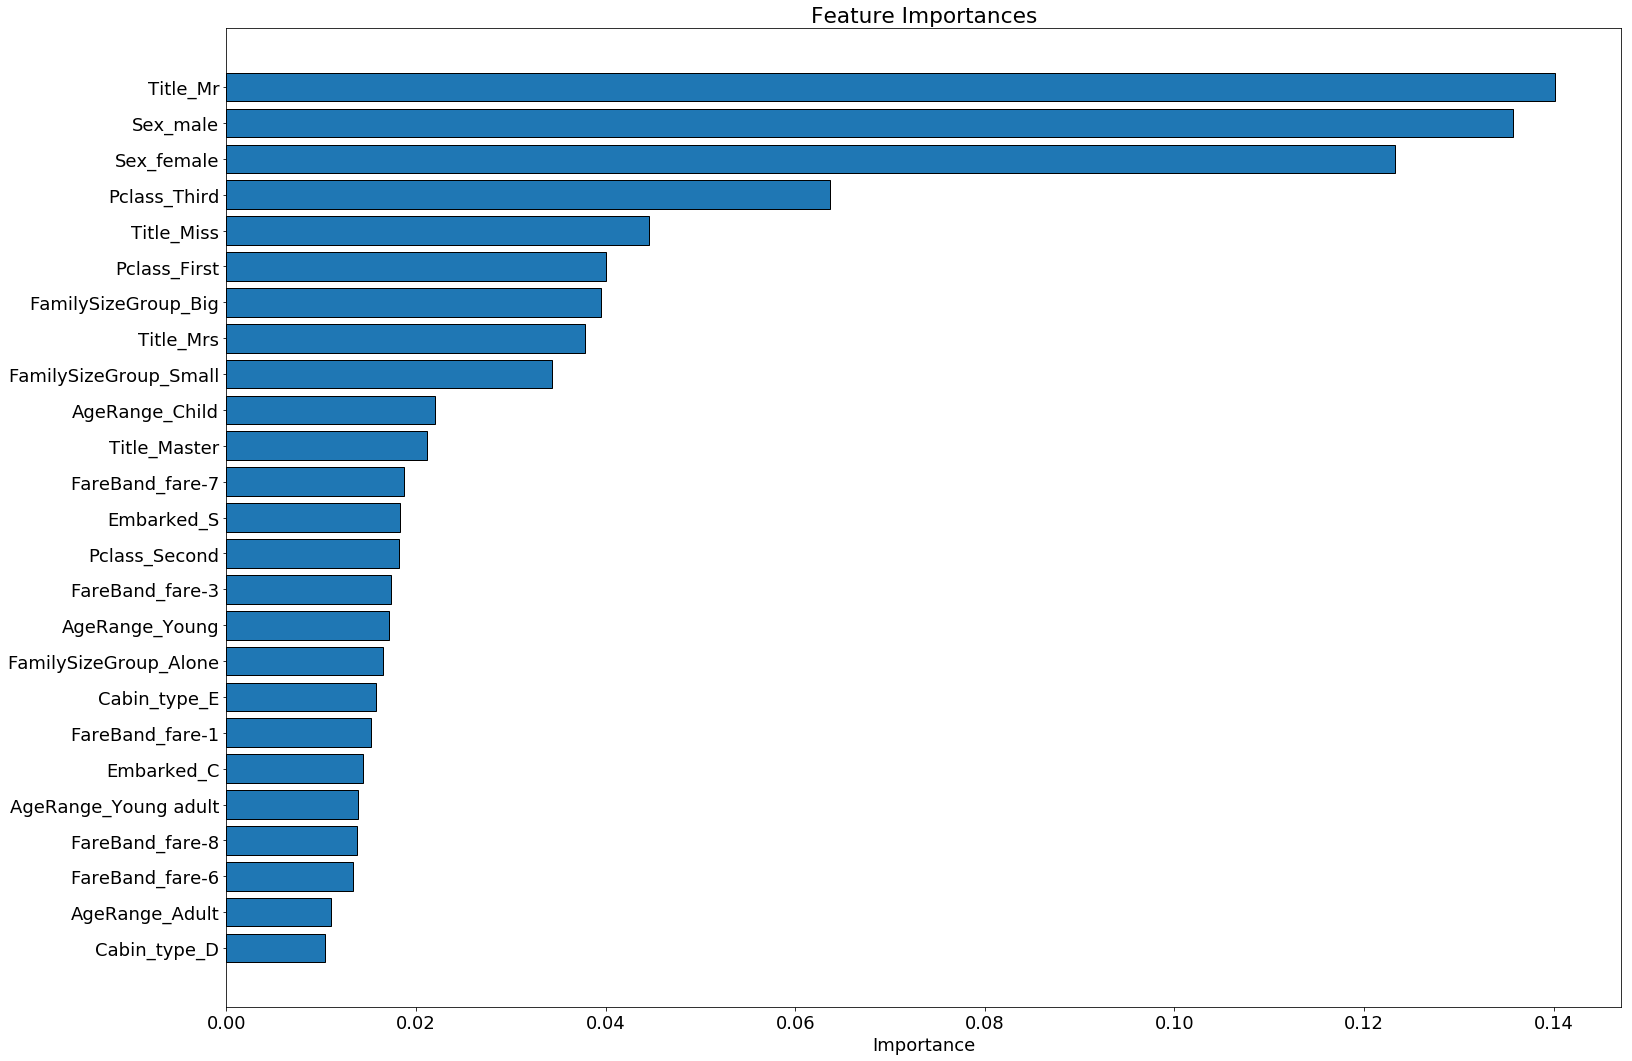

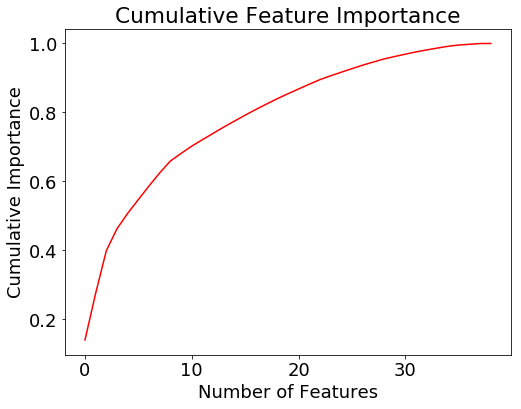

24 features required for 0.90 of cumulative importance


In [718]:
# Get the 15 features more important
feature_importances = rf.feature_importances_

feature_importances = pd.DataFrame({'feature': list(train_dataset_final.columns), 'importance': \
                                    feature_importances}).sort_values('importance', ascending = False)

def plot_feature_importances(df, threshold = 0.9):
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (25, 18))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:25]))), 
            df['importance_normalized'].head(25), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:25]))))
    ax.set_yticklabels(df['feature'].head(25))
    
    # Plot labeling
    plt.xlabel('Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

norm_feature_importances = plot_feature_importances(feature_importances)

# Correlations : feature_importances

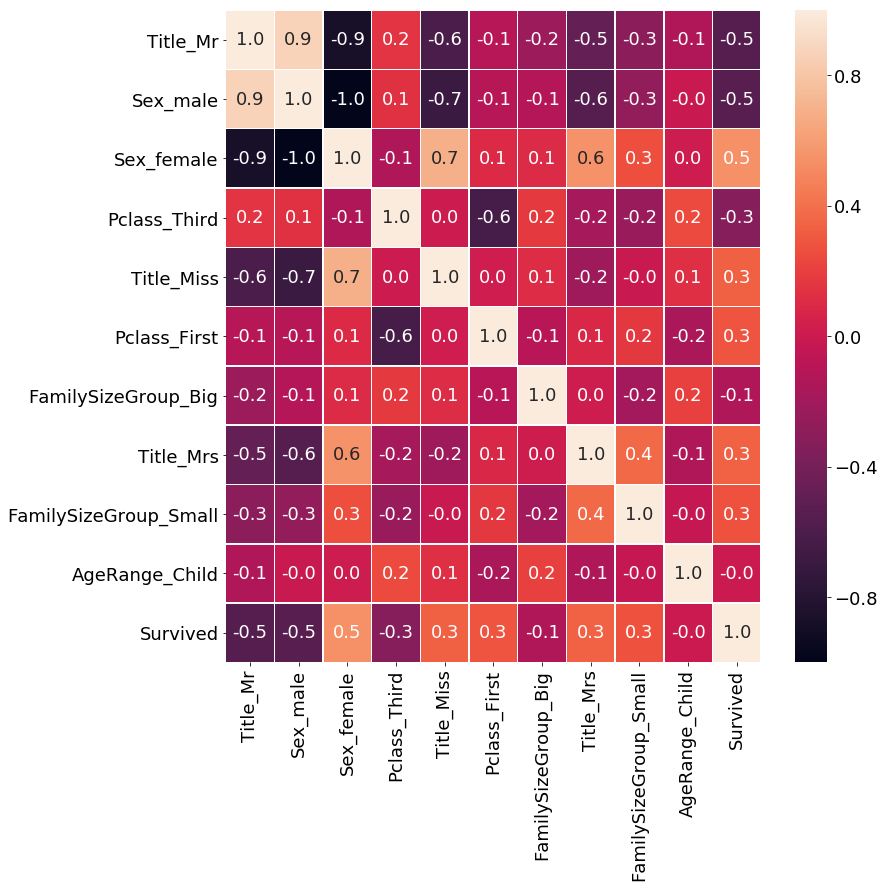

In [732]:
features = list(feature_importances["feature"].head(10))
grp = train_dataset_final[features]

grp["Survived"] = train_dataset_target

# map feature correlation
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(grp.corr(),annot=True, linewidths=.5, fmt= '.1f',ax=ax)

# Check some models

In [733]:
# Testing other models : cross validation
def compute_score(estimator, X, y, scoring='accuracy'):
    xval = cross_val_score(estimator, X, y, cv = 6, scoring=scoring)
    print("Cross validation = " + str(xval))
    return np.mean(xval)

logreg = LogisticRegression()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()
lg = LGBMClassifier()
ab = AdaBoostClassifier()

models = [logreg, rf, gboost, lg, ab]

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(estimator=model, X = train, y = train_dataset_target, scoring='accuracy')
    print('CV score = {0}'.format(score))

Cross-validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
Cross validation = [0.79194631 0.82550336 0.85234899 0.7972973  0.82432432 0.84459459]
CV score = 0.8226691456557229
Cross-validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
Cross validation = [0.7852349  0.74496644 0.84563758 0.83783784 0.77027027 0.83783784]
CV score = 0.8036308120200738
Cross-validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
Cross validation = [0.81879195 0.79865772 0.87919463 0.83783784 0.81756757 0.85135135]
CV score = 0.8339001753431283
Cross-validation of : <class 'lightgbm.sklearn.LGBMClassifier'>
Cross validation = [0.79865772 0.77181208 0.87919463 0.84459459 0.81081081 0.85135135]
CV score = 0.826070197714493
Cross-validation of : <class 'sklearn.ensemble.weight_boosting.AdaBoostClassifier'>
Cross validation = [0.75838926 0.81208054 0.83221477 0.79054054 0.84459459 0.84459459]
CV score = 0.8137357155813533


# HYPERPARAMETERS

In [740]:
# Hyperparameters in RandomForestClassifier()

randomforest_hyper = RandomForestClassifier()

# Some parameter combinations
parameters = {"n_estimators" : [100,200,1000],
              "max_depth": [4,6,10],
              "min_samples_leaf": [1,5],
              "max_features": ["auto"],
              "criterion": ["gini","entropy"]}

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(randomforest_hyper, parameters, scoring=acc_scorer)
grid_obj = grid_obj.fit(train, train_dataset_target)

# Get the best model
randomforest_hyper = grid_obj.best_estimator_

# Get the mean accuracy with the parameters
scores = cross_val_score(randomforest_hyper, train, train_dataset_target, cv = 3, scoring="accuracy")
print("Cross-validation scores: ")
print(scores)
print("Cross-validation scores mean: ")
print(scores.mean())

Cross-validation scores: 
[0.8047138  0.84511785 0.82828283]
Cross-validation scores mean: 
0.8260381593714928


# GET THE SUBMISSION

In [741]:
# Get the submission
proba_grad = randomforest_hyper.predict(test)

submit_grad = test_dataset[['PassengerId']]
submit_grad['Survived'] = proba_grad

submit_grad.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [742]:
# Save the submission to a csv file
submit_grad.to_csv('/home/convidado/Denise/TItanic/random_forest_grid.csv', index = False)
